In [1]:
# Kernel Density Estimation is a way to estimate smooth distribution of the data based on a set of discrete samples.
#
# The basic idea is to take the moving average of the sample points to smooth it out.
# See https://mathisonian.github.io/kde/ for a nice and interactive demo.

In [2]:
import pandas as pd

showcases_2011 = pd.read_csv("data/showcases.2011.csv.xz", index_col=0, skiprows=[1]).dropna().transpose()
showcases_2011.head(5)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
Sep. 19,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
Sep. 20,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
Sep. 21,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
Sep. 22,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
Sep. 23,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


In [3]:
import numpy as np
from scipy.stats import gaussian_kde, norm, poisson
from utils import Pmf

<Axes: >

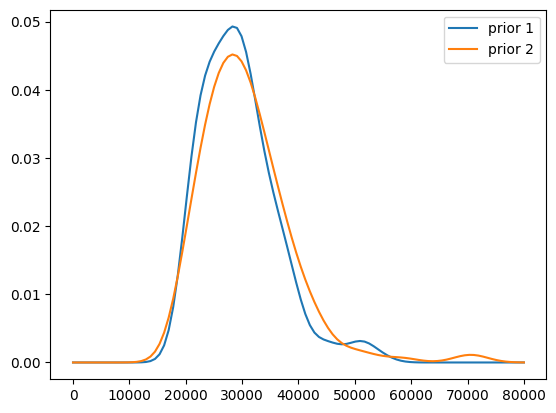

In [4]:
def make_kde(samples, qs):
    kde = gaussian_kde(samples)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

qs = np.linspace(0, 80000, 100)
prior1 = make_kde(showcases_2011['Showcase 1'], qs)
prior1.plot(label = "prior 1", legend=True)
prior2 = make_kde(showcases_2011['Showcase 2'], qs)
prior2.plot(label = "prior 2", legend=True)

<Axes: >

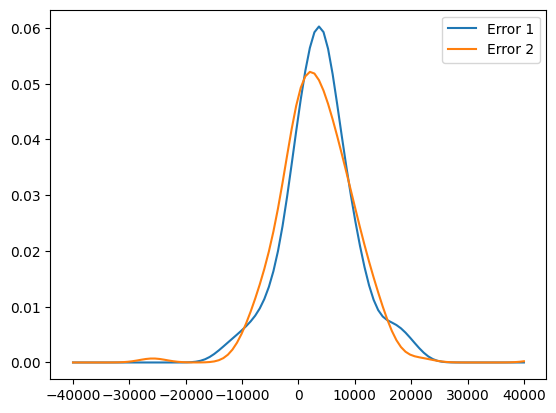

In [5]:
# distribution of error
err_qs = np.linspace(-40000, 40000, 100)
error1 = make_kde(showcases_2011['Difference 1'], err_qs)
error2 = make_kde(showcases_2011['Difference 2'], err_qs)
error1.plot(label = "Error 1", legend=True)
error2.plot(label = "Error 2", legend=True)

In [6]:
# i'm reading directly from the "Difference" column and the sign is opposite to the book. I'm going to keep it this way.
# so negative error = overbidding. 
mean_error1 = error1.mean()
std_error1 = error1.std()

print(mean_error1, std_error1)

3739.0157068062836 6450.422744169068


<Axes: >

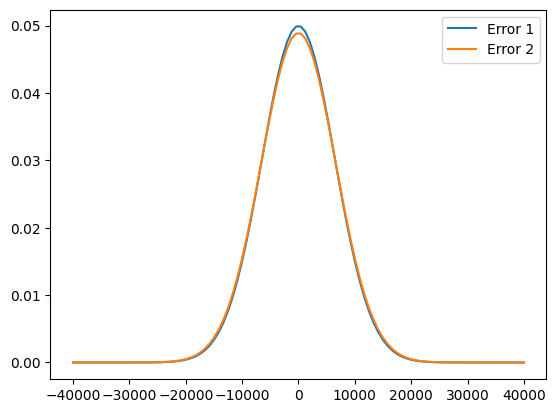

In [7]:
# make a normal distribution based on the mean and stddev
def norm_pmf(mean, std, qs):
    dist = norm(mean, std)
    pmf = Pmf(dist.pdf(qs), qs)
    pmf.normalize()
    return pmf


# the reason we use 0 as mean because we assume the contestants are purposefully underbidding, and their actual estimation would be accurate.
dist_error1 = norm(0, error1.std())
dist_error2 = norm(0, error2.std())

pmf_error1 = norm_pmf(0, error1.std(), err_qs)
pmf_error2 = norm_pmf(0, error2.std(), err_qs)

pmf_error1.plot(label = "Error 1", legend=True)
pmf_error2.plot(label = "Error 2", legend=True)

<Axes: >

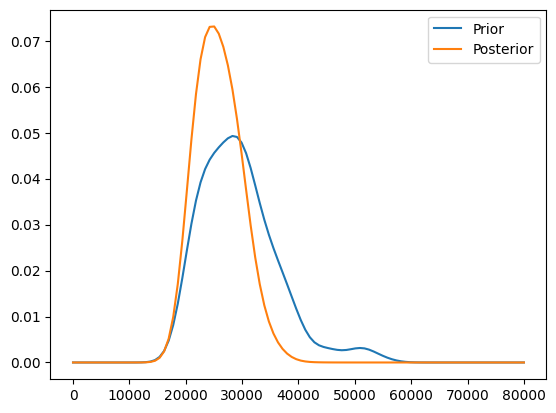

In [8]:
# suppose you play as player 1, and you estimate the price is 23,000. What's the distribution of the error of your estimation?
def update_guess(prior, guess, dist_error):
    diff = prior.qs - guess # remember: negative = overbidding
    likelihood = dist_error.pdf(diff)
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

pmf_post_guess_23000 = update_guess(prior1, 23000, dist_error1)
prior1.plot(label="Prior", legend=True)
pmf_post_guess_23000.plot(label="Posterior", legend=True)

<Axes: >

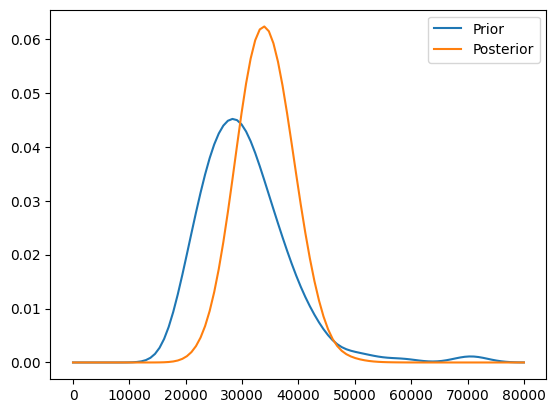

In [9]:
# suppose you play as player 2, and you guess 38000, what's the posterior distribution.

pmf_post_guess_38000 = update_guess(prior2, 38000, dist_error2)
prior2.plot(label="Prior", legend=True)
pmf_post_guess_38000.plot(label="Posterior", legend=True)

In [10]:
def prob_overbid(diff_samples):
    return (diff_samples < 0).mean()

# each arg can take a number or a series.
def prob_worse_than(diff1, diff2):
    return (diff1 > diff2).mean()

(prob_overbid(showcases_2011['Difference 1']),
 prob_worse_than(showcases_2011['Difference 1'], 5000))

(0.23036649214659685, 0.387434554973822)

In [11]:
def compute_prob_win(diff1, diff_samples2):
    if diff1 < 0:
        return 0
    # opponent overbid
    p_ob = prob_overbid(diff_samples2)
    # bids closer to opponent
    p_wt = prob_worse_than(diff_samples2, diff1)
    # mutually exclusive since we already excluded the case for player 1 overbids.
    return p_ob + p_wt

<Axes: >

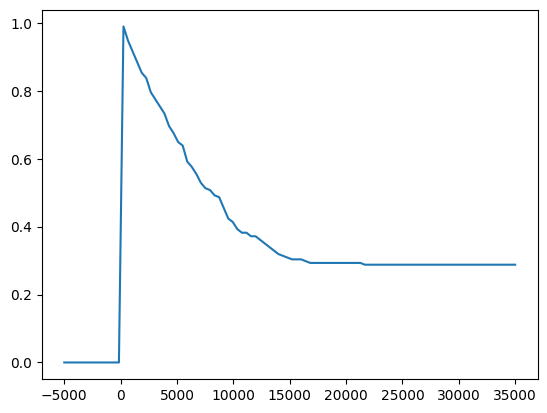

In [12]:
# probability for winning probability for different value of real differences for player 1.
xs = np.linspace(-5000, 35000, 100)
ys = [compute_prob_win(x, showcases_2011['Difference 2']) 
      for x in xs]
Pmf(ys, xs).plot()

In [13]:
# the result is expected. overbidding = lose. so it's best to underbid but as close to the real price as possible.

In [14]:
# if we know the actual price, we would know the winning probability for a given difference in actual bid.
# what if we don't know the actual price? instead we have a posterior on the distribution of the actual price after we made our initial guess?

def total_win_prob(bid, posterior, diff_samples):
    total = 0
    for actual_price, prob in posterior.items():
        diff = actual_price - bid
        total += prob * compute_prob_win(diff, diff_samples)
    return total

total_win_prob(25000, pmf_post_guess_23000, showcases_2011['Difference 2'])

0.4422866604785982

<Axes: >

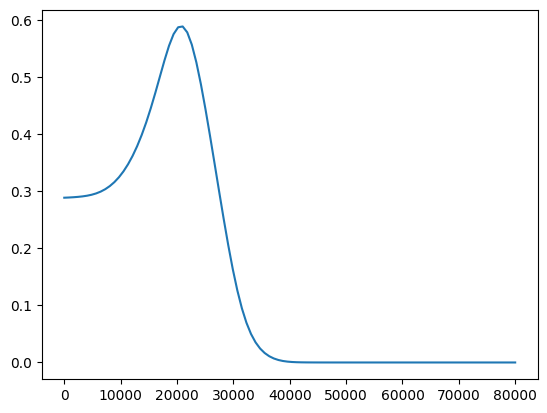

In [15]:
def win_prob_after_guess(guess, prior, diff_samples, error_dist):
    posterior = update_guess(prior, guess, error_dist)
    qs = posterior.qs
    ps = [total_win_prob(q, posterior, diff_samples) for q in qs]
    return Pmf(ps, qs)

prob_win_series = win_prob_after_guess(23000, prior1, showcases_2011['Difference 2'], dist_error1)
prob_win_series.plot()

In [16]:
prob_win_series.normalize()

(prob_win_series.idxmax(), prob_win_series.mean())

(21010.10101010101, 16333.7926261847)

21818.18181818182

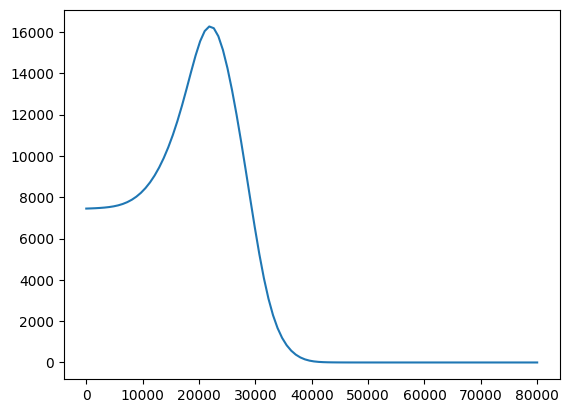

In [17]:
# in this game show, if you bid within 250$ of the actual price, you get the both prizes.
# so it may worth the risk to bid higher (closer to the actual price) for the larger reward.

def compute_gain(bid, price, diff_samples):
    diff = price - bid
    prob = compute_prob_win(diff, diff_samples)
    
    if bid > price:
        return 0

    if price - bid <= 250:
        return price * 2 * prob

    if price - bid > 250:
        return price * prob

def expected_gain(bid, posterior, diff_samples):
    est = 0
    for price, prob in posterior.items():
        est += compute_gain(bid, price, diff_samples) * prob
    return est

def expected_gain_by_bid(guess, prior, diff_samples, error_dist):
    posterior = update_guess(prior, guess, error_dist)
    qs = posterior.qs
    ps = [expected_gain(q, posterior, diff_samples) for q in qs]
    return Pmf(ps, qs)

est_gain_series = expected_gain_by_bid(23000, prior1, showcases_2011['Difference 2'], dist_error1)
est_gain_series.plot()
est_gain_series.idxmax()

In [18]:
# redline problem: unpredicatable subway arrival.
#
# the trains run every 7-8 minutes. we can estimate the mean interval between arrival to be around 7.5 min
#
# there is likely 10 person waiting, which should happen mostly likely at that 7.5/2 time.
# fewer waiting people implies a train passed recently. more people implies the train is about to arrive.
#

(7.775556961347175, 2.9526365957524296)
(8.8908723202397, 2.739888726121067)
0.016078998906924623


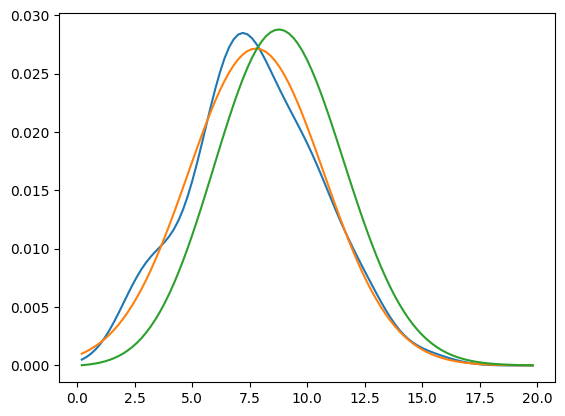

In [144]:
# the estimated train arrival time does not follow an exponential distribution. This is obvious for two reasons:
# 1. it is NOT the case that the most likely arrival would be immediately after the previous train's arrival
# 2. the trains are dispatched at an accurate interval at start, and deviates during trip. so it may look more like a normal distribution.

# the linked notebook provides some data on the observed gap time for the trains (in seconds), let's just use it.
observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]
# convert to minutes
observed_gap_times = [t / 60.0 for t in observed_gap_times]

hypos = np.arange(0.2, 20, 0.2)
gap_time_kde = make_kde(observed_gap_times, hypos)
gap_time_kde.plot()
gap_time_dist = norm(gap_time_kde.mean(), gap_time_kde.std())
gap_time_pmf = Pmf([gap_time_dist.pdf(h) for h in hypos], hypos)
gap_time_pmf.normalize()
gap_time_pmf.plot()
print((gap_time_kde.mean(), gap_time_kde.std()))

# the "inspection paradox". if we come to the station, we're more likely at the longer gap. the likelihood is proportional to the duration.
# this paradox is very interesting and seemingly contradicting common sense.
gap_time_pmf_posterior = gap_time_pmf * gap_time_pmf.qs
gap_time_pmf_posterior.normalize()
gap_time_pmf_posterior.plot()
print((gap_time_pmf_posterior.mean(), gap_time_pmf_posterior.std()))

# actually, there is only <2% possibility that the gap time is longer than his expected wait time (15 min).
print(gap_time_pmf_posterior.prob_ge(15))

<Axes: >

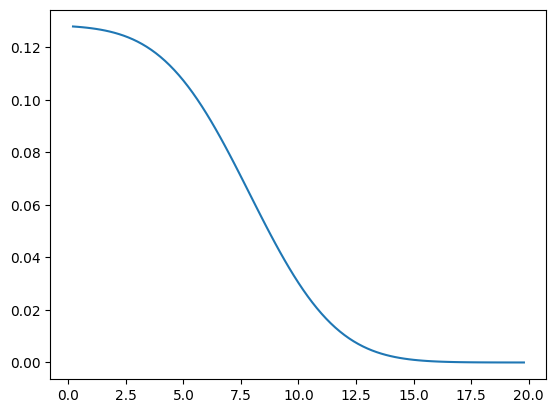

In [121]:
# we now model the estimated elapsed time.
# for each gap time, we arrive during this gap time for a certain probability, given by gap_time_pmf_posterior.
# then at each of the gap time, the actual time we arrive is a uniform distribution [0, gap_time).
#
# so the estimated elapsed time can be modeled as a mixture between gap_time_pmf_posterior, and [0, gap_time)
#
# (thought: this starts to look extremely close to a monadic bind to me... let me just write a variant of mix with the bind signature)
def mix_bind(prior, f):
    pmfs = [f(q) for q in prior.qs]
    df = pd.DataFrame(pmfs).fillna(0).transpose()
    df *= np.array(prior.ps)
    return Pmf(df.sum(axis=1))

import functools

@functools.cache
def elapsed_time_prob(gap_time):
    qs = gap_time_pmf_posterior.qs[gap_time_pmf_posterior.qs <= gap_time]
    return Pmf(1/gap_time, qs)

elapsed_pmf = mix_bind(gap_time_pmf_posterior, elapsed_time_prob)
elapsed_pmf.plot()

<Axes: >

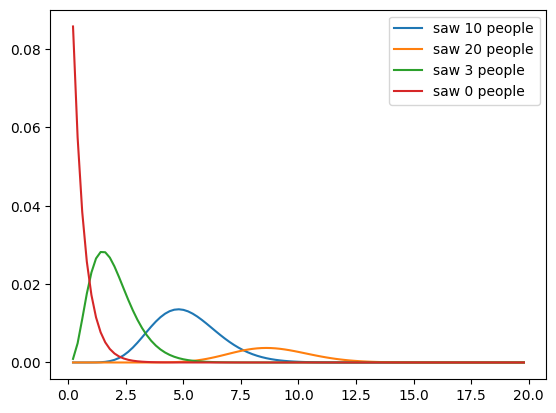

In [122]:
# now let's model the probability of seeing a given number of people at any time.
# we assume the number of people per minute follows a poisson distribution of a constant lambda.

@functools.cache
def prob_people_saw(people_saw, lam, elpased_time):
    return poisson(lam * elpased_time).pmf(people_saw)

def elapsed_pmf_posterior(people_saw, lam, elapsed_pmf):
    return elapsed_pmf.bayes(lambda t: prob_people_saw(people_saw, lam, t))

elapsed_pmf_posterior(10, 2, elapsed_pmf).plot(label="saw 10 people")
elapsed_pmf_posterior(20, 2, elapsed_pmf).plot(label="saw 20 people")
elapsed_pmf_posterior(3, 2, elapsed_pmf).plot(label="saw 3 people")
elapsed_pmf_posterior(0, 2, elapsed_pmf).plot(label="saw 0 people")

<Axes: >

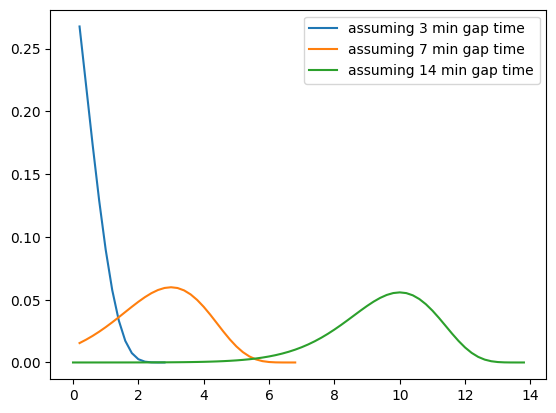

In [130]:
# we modeled the waiting time based on the number of people.
# but how about the remaining wait time?

@functools.cache
def wait_time_prob(gap_time, people_saw, lam):
    elapsed_pmf = elapsed_time_prob(gap_time)
    elapsed_pmf = elapsed_pmf_posterior(people_saw, lam, elapsed_pmf)
    qs = gap_time - elapsed_pmf.qs
    ps = elapsed_pmf.ps
    qps = list(reversed(list(zip(qs, ps))))
    # the rounding is necessary because there is floating point error introduced somewhere, which behaves badly with the mix_bind step.
    qs = [round(x[0], 2) for x in qps]
    ps = [x[1] for x in qps]
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

def mix_bind(prior, f):
    pmfs = [f(q) for q in prior.qs]
    df = pd.concat(pmfs, axis=1).fillna(0) * prior.ps
    return Pmf(df.sum(axis=1))

wait_time_prob(3, 8, 2).plot(label="assuming 3 min gap time")
wait_time_prob(7, 8, 2).plot(label="assuming 7 min gap time")
wait_time_prob(14, 8, 2).plot(label="assuming 14 min gap time")
# x-axis: wait time
# y-axis: probability of such wait time

<Axes: >

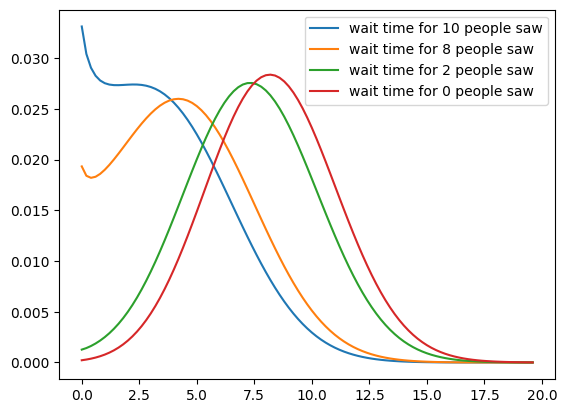

In [131]:
def wait_time_posterior(people_saw, lam, gap_time_pmf):
    return mix_bind(gap_time_pmf_posterior, lambda t: wait_time_prob(t, people_saw, lam))

wait_time_posterior(10, 2, gap_time_pmf).plot(label="wait time for 10 people saw")
wait_time_posterior(8, 2, gap_time_pmf).plot(label="wait time for 8 people saw")
wait_time_posterior(2, 2, gap_time_pmf).plot(label="wait time for 2 people saw")
wait_time_posterior(0, 2, gap_time_pmf).plot(label="wait time for 0 people saw")
# x-axis: wait time
# y-axis: probability of such wait time

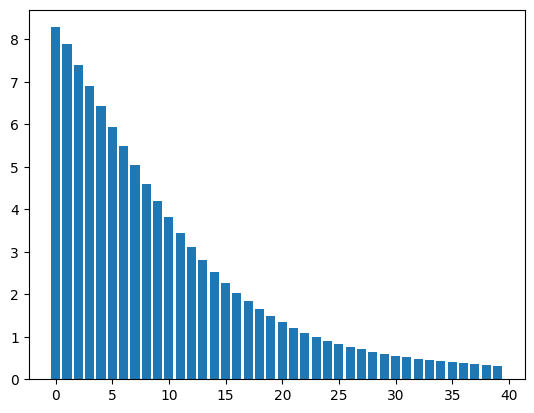

In [132]:
people = np.arange(0, 40)
mean_wait_time = [wait_time_posterior(n, 2, gap_time_pmf).mean() for n in people]
Pmf(mean_wait_time, people).bar()

<Axes: >

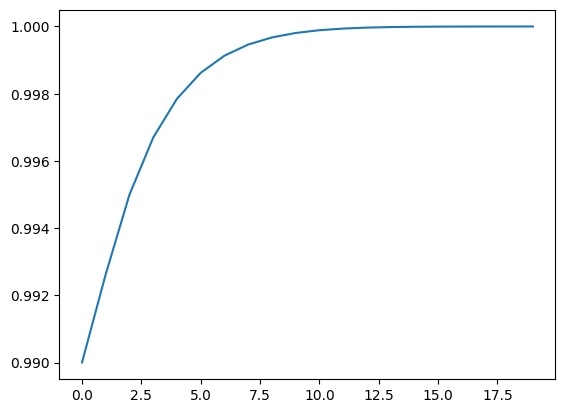

In [151]:
# we want a probability of catching up the next train (i.e. train arriving within 15 min) for each number of people saw
people = range(0, 20)
prob_catchup = [wait_time_posterior(n, 2, elapsed_pmf).prob_lt(15) for n in people]

from empiricaldist import Cdf

cdf = Cdf(prob_catchup, people)
cdf.plot()

<Axes: >

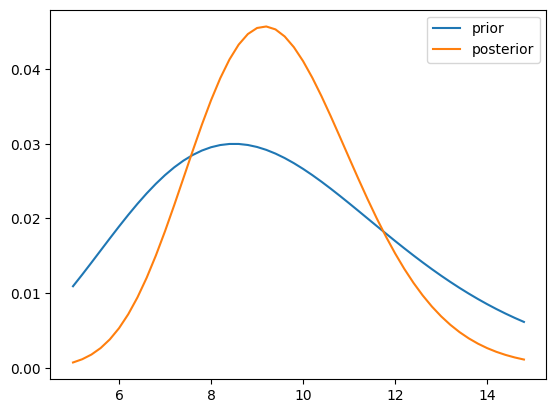

In [199]:
# Exercise on book selling. Model the decision process.
#
# - we assuem the book sales per week follows a poisson distribution.
# - 10 sales in the first week, 9 in the second
# - the cost of printing the book is $5 per copy. If you order 100 or more, it's $4.5 per copy
# - every book sells for $10
# - if you run out of book before the end of 8 weeks, you lose $50 for every week out of stock
# - if you have books left over at the end of 8 weeks, you lose $2 cost per extra book
#
# how to maximize the expected profit.

# first we model the number of sales per week and find the value of lambda (parameter in poisson distribution).

from scipy.stats import gamma

def make_gamma_prior(alpha, qs):
    ps = gamma(alpha).pdf(qs)
    prior = Pmf(ps, qs)
    prior.normalize()
    return prior

def update_sales(prior, data):
    qs = prior.qs
    posterior = Pmf(prior.copy())
    for n in data:
        likelihood = poisson(qs).pmf(n)
        posterior *= likelihood
    posterior.normalize()
    return posterior

sale_rate_pmf_prior = make_gamma_prior(9.5, np.arange(5, 15, 0.2))
sale_rate_pmf = update_sales(sale_rate_pmf_prior, [10, 9])

sale_rate_pmf_prior.plot(label="prior")
sale_rate_pmf.plot(label="posterior")

<Axes: >

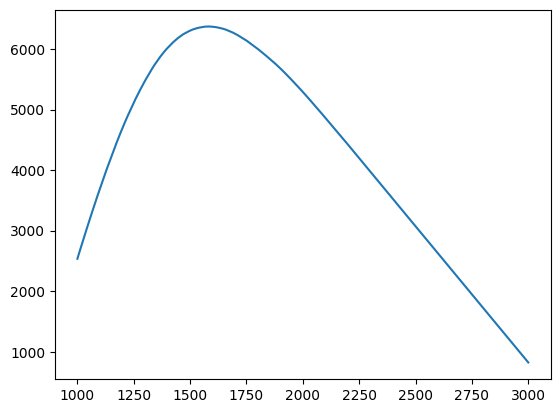

In [238]:
def printing_cost(n_prints):
    if n_prints >= 100:
        return 4.5 * n_prints
    else:
        return 5 * n_prints

# the following logic isn't exactly as stated in the exercise description.
# the description seems to imply that the out of stock/inventory cost only
# applies after 8 weeks of booksale, but I found that inconsistent with
# the provided solution.
def out_of_stock_cost(n_prints, sales):
    cost = 0
    remaining = n_prints
    for sale in sales:
        if remaining < 0:
            cost += 50
        remaining -= sale
    return cost

def inventory_cost(n_prints, sales):
    inventory = sum(sales) - n_prints
    if inventory > 0:
        return inventory * 2
    else:
        return 0

def revenue(n_prints, sales):
    return min(sum(sales), n_prints) * 10

def profit(n_prints, sales):
    cost = printing_cost(n_prints) + inventory_cost(n_prints, sales) + out_of_stock_cost(n_prints, sales)
    return revenue(n_prints, sales) - cost

def sale_sequences(sale_rate_pmf, n_samples, n_weeks):
    sale_rates = sale_rate_pmf.choice(n_samples)
    return [[np.random.poisson(rate) for _ in range(n_weeks)] for rate in sale_rates]

def profit_graph(sale_rate_pmf, n_weeks, n_prints_min, n_prints_max):
    n_print_values = range(n_prints_min, n_prints_max+1)
    sales_values = sale_sequences(sale_rate_pmf, 1000, n_weeks)
    mean_profits = []
    for n_print in n_print_values:
        mean_profit = np.array([profit(n_print, sales) for sales in sales_values]).mean()
        mean_profits.append(mean_profit)
    return pd.Series(mean_profits, n_print_values)

graph = profit_graph(sale_rate_pmf, 150, 1000, 3000)
graph.plot()

In [ ]:
# i found the optimal copies heavily depend on the number of weeks you plan to sell the book.
# This makes sense because selling a book for longer implies more books being sold, and
# intuitively it's most profitable when n_sold = n_printed.
#
# so in the long run, you should print sale_rate_pmf.mean() * n_weeks copies of the book.